# 1D Multilevel Development: Repetitive + Alignment (Laplace)
* Constant $k$.
* Discretization: 5-point (4th order).
* Kaczmarz relaxation.
* Fixed-domain problem; repetitive, so we sample windows from a test vector.

In [37]:
import collections
import logging
import numpy as np
import matplotlib.pyplot as plt
import helmholtz as hm
import pandas as pd
import scipy.sparse
import sklearn.metrics.pairwise
import sys
from numpy.ma.testutils import assert_array_almost_equal
from scipy.linalg import eig, norm, svd
from scipy.sparse.linalg import eigs
from scipy import optimize

%load_ext autoreload
%autoreload 2

np.set_printoptions(linewidth=500, precision=3, suppress=True, threshold=100000)
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(levelname)-8s %(message)s",
                    datefmt="%a, %d %b %Y %H:%M:%S")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = "{:,.2f}".format

logger = logging.getLogger("main")
_LOGGER = logger

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
# Fixed seed for reproducible results.
np.random.seed(1)

# Domain size.
n = 96
# Scaled wave number.
kh = 0.5

repetitive = True

# Number of test vectors.
num_examples = 3
threshold = 0.1

# Boottstrapping parameters.
interpolation_method = "ls"
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5
leeway_factor = 1.3

## Shrinkage Factor
Given an iterative method, we can calculate whether it's a good smoothing candidate using the **shrinkage factor** $\mu$, even before measuring its mock cycle rate (which measures the combination of the smoother andcoarsening operator $R$).

* Start from $5$ different random starts $x_0 = rand[-1,1]$, for each  apply the method for $A x = 0$ to obtain iterates $x_1, x_2, \dots$.
* For each iterate, calculate residual norm $r_i := \|A x_i\|_2$ and reduction per sweep, $\mu_i := (r_i / r_0)^{\frac{1}{i}}$, $i = 1, 2, \dots$.
* Average $\mu_i$ over the $5$ starts.
* Terminate the method at $j = i + 3$, where $i = argmin_i \mu_i$ and set $\mu \leftarrow \mu_j$.

## Level 0->1 Coarsening

### Relaxation Shrinkage Factor

PODR = point of diminishing returns
Efficiency = residual reduction per sweep
kh 0.5
INFO     Iter     |r|                         |x|         RER
INFO     0     1.325e+00                    4.468e-01    2.959
INFO     1     7.276e-01 (0.550) [0.550]    3.417e-01    2.130 (0.719)
INFO     2     4.232e-01 (0.583) [0.566]    2.926e-01    1.450 (0.681)
INFO     3     2.661e-01 (0.630) [0.587]    2.675e-01    0.999 (0.689)
INFO     4     1.831e-01 (0.689) [0.611]    2.526e-01    0.728 (0.729)
INFO     5     1.383e-01 (0.755) [0.638]    2.426e-01    0.572 (0.787)
INFO     6     1.126e-01 (0.814) [0.664]    2.351e-01    0.480 (0.839)
INFO     7     9.662e-02 (0.857) [0.689]    2.291e-01    0.422 (0.880)
INFO     8     8.570e-02 (0.886) [0.711]    2.240e-01    0.382 (0.906)
INFO     9     7.765e-02 (0.905) [0.730]    2.197e-01    0.353 (0.923)
INFO     10    7.135e-02 (0.918) [0.747]    2.158e-01    0.330 (0.935)
Kac   conv 0.92 shrinkage 0.71 PODR RER 0.38 after  8 sweeps. Work  1 efficiency

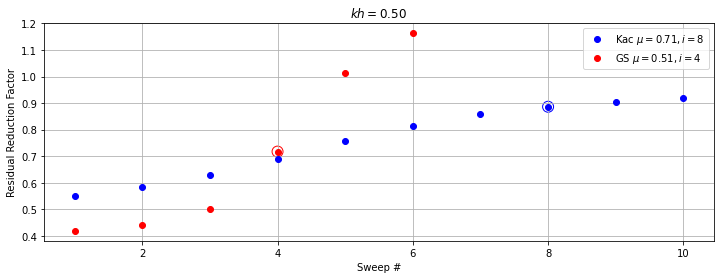

In [39]:
kh_values = [kh]
fig, axs = plt.subplots(1, len(kh_values), figsize=(12, 4))
if len(kh_values) == 1:
    axs = [axs]

kaczmarz = lambda a: hm.solve.relax.KaczmarzRelaxer(a, scipy.sparse.eye(a.shape[0]))
gs = lambda a: hm.solve.relax.GsRelaxer(a)
work = 1

print("PODR = point of diminishing returns")
print("Efficiency = residual reduction per sweep")
# Kaczmarz.
for kh_value, ax in zip(kh_values, axs):
    print("kh", kh_value)
    a_kh = hm.linalg.helmholtz_1d_5_point_operator(kh_value, n).tocsr()
    operator = lambda x: a_kh.dot(x)

    for title, relax, color in zip(("Kac", "GS"), (kaczmarz, gs), ("blue", "red")):
        method = relax(a_kh)
        factor, num_sweeps, residual, conv, rer, conv_factor = hm.solve.smoothing.shrinkage_factor(
            operator, lambda x, b: method.step(x, b), (a_kh.shape[0], ), 
            print_frequency=1, max_sweeps=10, slow_conv_factor=1.1, leeway_factor=leeway_factor)
        hm.solve.smoothing.plot_diminishing_returns_point(factor, num_sweeps, conv, ax, title=title, color=color)
        print("{:<5s} conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {:>2d} sweeps. Work {:>2d} efficiency {:.2f}".format(
            title, conv_factor, factor, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / residual[0]) ** (1/(num_sweeps * work))))
    
    ax.set_title(r"$kh = {:.2f}$".format(kh_value))
    ax.legend()

The point of diminishing returns in each scatterplot is circled.

This estimate seems to give a reasonable estimate for both $kh$ values and both relaxation schemes (albeit not a quantitative smoothing factor, which can only be defined based on a coarsening), showing that GS is a better smoother for both $kh = 0, 0.5$, but slightly diverges for $kh = 0.5$. The RER at the point of diminishing returns is much smaller.

Averaging over multiple random starts helps reduce noise, as well as assuming a constant reduction per sweep in the initial sweeps (as opposed to a linear model, say). We are only interested in a rough estimate.

**TODO: output asymptotic convergence factor a little past PODR to see if relax diverges.**

### Coarsening: Optimizing $a$, $n_c$

In [40]:
a = hm.linalg.helmholtz_1d_5_point_operator(kh, n).tocsr()
a0 = a
level = hm.setup.hierarchy.create_finest_level(a)

In [41]:
_LOGGER.info("kh {}".format(kh))
x_log = []
r_log = []

# Initialize hierarchy to 1-level and fine-level test functions to random.
finest = 0
multilevel = hm.hierarchy.multilevel.Multilevel.create(level)

_LOGGER.info("Relax at level {} size {}".format(finest, level.size))
b = np.zeros((a.shape[0], num_examples))

factor, num_sweeps, residual, conv, rer, relax_conv_factor = hm.solve.smoothing.shrinkage_factor(
    operator, lambda x, b: level.relax(x, b), (a_kh.shape[0], ), 
    print_frequency=None, max_sweeps=20, slow_conv_factor=1.1)
_LOGGER.info("Relax conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {} sweeps. Work {:.1f} eff {:.2f}".format(
    relax_conv_factor, factor, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / residual[0]) ** (1/(num_sweeps * work))))

# TODO(orenlivne): generalize to d-dimensions. This is specific to 1D.
x = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
# Improve vectors with 1-level relaxation.
x_log.append(x)

_LOGGER.info("Generating TVs with {} sweeps".format(num_sweeps))
x, _ = hm.solve.run.run_iterative_method(
    level.operator, lambda x: level.relax(x, b), x, num_sweeps=num_sweeps)
_LOGGER.info("RER {:.3f}".format(norm(a.dot(x)) / norm(x)))
x_log.append(x)

INFO     kh 0.5
INFO     Relax at level 0 size 96
INFO     Relax conv 0.93 shrinkage 0.63 PODR RER 0.58 after 5 sweeps. Work 1.0 eff 0.63
INFO     Generating TVs with 5 sweeps
INFO     RER 0.551


In [42]:
coarsener = hm.setup.coarsening_uniform.UniformCoarsener(
    level, x, num_sweeps, repetitive=repetitive)
info = coarsener.get_coarsening_info(1, fmt="dataframe")
r, aggregate_size, nc, cr, mean_energy_error, mock_conv, mock_work, mock_efficiency = \
    coarsener.get_optimal_coarsening(1)
_LOGGER.info("R {} a {} nc {} cr {:.2f} mean_energy_error {:.4f}; mock cycle num_sweeps {} conv {:.2f} "
             "eff {:.2f}".format(
    r.shape, aggregate_size, nc, cr, mean_energy_error, num_sweeps, mock_conv, mock_efficiency))

INFO     R (48, 96) a 4 nc 2 cr 0.50 mean_energy_error 0.3133; mock cycle num_sweeps 5 conv 0.15 eff 0.83


In [43]:
coarsener.get_coarsening_info(1, fmt="dataframe")

,i,a,nc,cr,Energy Error,conv,work,eff
0,0,2,1,0.50,0.56,0.21,10.00,0.86
1,1,3,1,0.33,0.60,0.55,9.17,0.94
2,2,3,2,0.67,0.12,0.08,15.00,0.85
3,3,4,1,0.25,0.65,0.85,8.75,0.98
4,4,4,2,0.50,0.31,0.15,10.00,0.83
5,5,6,1,0.17,0.60,0.90,8.33,0.99
6,6,6,2,0.33,0.38,0.54,9.17,0.94
7,7,6,3,0.50,0.17,0.11,10.00,0.80
8,8,6,4,0.67,0.06,0.06,15.00,0.83
9,9,8,1,0.12,0.75,0.92,8.12,0.99


The optimal coarsening (based on mock cycle efficiency) is for a larger aggregate ($4/2$) only for a sufficiently large $kh$, of $\approx 0.7$. Even at $kh = 0.5$, $2/1$ coarsening is (very slightly) better.

### Build Coarse Level: Two-level Bootstrap Cycle

In [44]:
max_levels = 2
num_bootstrap_steps = 1

# Bootstrap with an increasingly deeper hierarchy (add one level at a time).
num_levels = 2
_LOGGER.info("bootstrap on grid size {} with {} levels".format(x.shape[0], max_levels))
_LOGGER.info("-" * 80)
for i in range(num_bootstrap_steps):
    _LOGGER.info("Bootstrap step {}/{}".format(i + 1, num_bootstrap_steps))
    # Set relax_conv_factor to a high value so that we never append a bootstrap vector to the TV set.
    x, multilevel = hm.setup.auto_setup.bootstap(
        x, multilevel, num_levels, 2.0,
        num_sweeps=num_sweeps, interpolation_method=interpolation_method, 
        neighborhood=neighborhood, repetitive=repetitive, target_error=0.1)
    x_log.append(x)
    r_log.append(multilevel[1].r)
    _LOGGER.info("RER {:.6f}".format(norm(a.dot(x)) / norm(x)))
    _LOGGER.info("-" * 80)

INFO     bootstrap on grid size 96 with 2 levels
INFO     --------------------------------------------------------------------------------
INFO     Bootstrap step 1/1
INFO     Relax cycle conv factor 0.945 asymptotic RQ 0.204 RER 0.241 P error -1.000
INFO     Improving vectors by relaxation cycles
INFO     Coarsening level 0->1
INFO     R (64, 96) a 3 nc 2 cr 0.67 mean_energy_error 0.0715; mock cycle num_sweeps 5 conv 0.07 eff 0.84
INFO     Mock cycle conv factor [0.393 0.275 0.163 0.071] for nu [1 2 3 5]
INFO     caliber 1 error l2 [0.4] a [4.66]
INFO     caliber 2 error l2 [0.05] a [1.15]
INFO     all  set size 3  P L2 error mean 0.05 max 0.06 A error mean 0.24 max 0.27
INFO     Level 1 size 64
INFO     RER 0.203665
INFO     --------------------------------------------------------------------------------


<!-- ### Interpolation Error -->

### Operators

#### Level 0

In [45]:
pd.DataFrame(multilevel[0].a[:10,:10].todense())

,0,1,2,3,4,5,6,7,8,9
0,-2.25,1.33,-0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,1.33,-2.25,1.33,-0.08,0.00,0.00,0.00,0.00,0.00,0.00
2,-0.08,1.33,-2.25,1.33,-0.08,0.00,0.00,0.00,0.00,0.00
3,0.00,-0.08,1.33,-2.25,1.33,-0.08,0.00,0.00,0.00,0.00
4,0.00,0.00,-0.08,1.33,-2.25,1.33,-0.08,0.00,0.00,0.00
5,0.00,0.00,0.00,-0.08,1.33,-2.25,1.33,-0.08,0.00,0.00
6,0.00,0.00,0.00,0.00,-0.08,1.33,-2.25,1.33,-0.08,0.00
7,0.00,0.00,0.00,0.00,0.00,-0.08,1.33,-2.25,1.33,-0.08
8,0.00,0.00,0.00,0.00,0.00,0.00,-0.08,1.33,-2.25,1.33
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.08,1.33,-2.25


#### Level 1

In [46]:
pd.DataFrame(multilevel[1].a[:10,:10].todense())

,0,1,2,3,4,5,6,7,8,9
0,-0.49,-0.19,0.34,-0.62,0.00,0.00,0.00,0.00,0.00,0.00
1,-0.19,-2.09,0.35,-0.63,0.00,0.00,0.00,0.00,0.00,0.00
2,0.34,0.35,-0.49,-0.19,0.34,-0.62,0.00,0.00,0.00,0.00
3,-0.62,-0.63,-0.19,-2.09,0.35,-0.63,0.00,0.00,0.00,0.00
4,0.00,0.00,0.34,0.35,-0.49,-0.19,0.34,-0.62,0.00,0.00
5,0.00,0.00,-0.62,-0.63,-0.19,-2.09,0.35,-0.63,0.00,0.00
6,0.00,0.00,0.00,0.00,0.34,0.35,-0.49,-0.19,0.34,-0.62
7,0.00,0.00,0.00,0.00,-0.62,-0.63,-0.19,-2.09,0.35,-0.63
8,0.00,0.00,0.00,0.00,0.00,0.00,0.34,0.35,-0.49,-0.19
9,0.00,0.00,0.00,0.00,0.00,0.00,-0.62,-0.63,-0.19,-2.09


In [47]:
pd.DataFrame(multilevel[1].p[:10, :10].todense())

,0,1,2,3,4,5,6,7,8,9
0,-0.46,0.77,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,-0.62,0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,-0.64,-0.61,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,-0.46,0.77,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,-0.62,0.07,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,-0.64,-0.61,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,-0.46,0.77,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,-0.62,0.07,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,-0.64,-0.61,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,-0.46,0.77,0.00,0.00


In [48]:
pd.DataFrame(multilevel[1].r[:10,:10].todense())

,0,1,2,3,4,5,6,7,8,9
0,-0.43,-0.66,-0.61,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.78,0.07,-0.62,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,-0.43,-0.66,-0.61,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.78,0.07,-0.62,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,-0.43,-0.66,-0.61,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.78,0.07,-0.62,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.43
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.78
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


# Test Multilevel Cycle Convergence

### Solving $A x = b$ (Periodic Fixed-Size Domain Problem)
That is, solving on a periodic fixed domain. $b$ is a random periodic vector. We start from random $x$. Solving exactly on the coarsest level works fine despite the indefiniteness since the matrix is not (even nearly) singular.

In [66]:
level = multilevel.finest_level
# Test two-level cycle convergence for A*x=0 and  A*x=b with random b.
for title, b in (("0", np.zeros((a0.shape[0], ))), ("b", np.random.random((a0.shape[0], )))):
    logger.info("Ax={}".format(title))
    two_level_cycle = lambda y: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, 1, 0, nu_coarsest=-1, debug=False, rhs=b).run(y)
    residual = lambda x: b - multilevel[0].operator(x)
    x, conv_factor = hm.solve.run.run_iterative_method(residual, two_level_cycle, np.random.random((a0.shape[0], )), 20, print_frequency=1)

INFO     Ax=0
INFO         0 |r| 7.817e+00 RER 1.43240
INFO         1 |r| 3.484e+00 (0.44569) RER 2.61095 (1.82278) 1.334
INFO         2 |r| 5.778e-01 (0.16585) RER 2.73214 (1.04642) 0.211
INFO         3 |r| 1.085e-01 (0.18773) RER 2.75303 (1.00764) 0.039
INFO         4 |r| 2.018e-02 (0.18604) RER 2.70336 (0.98196) 0.007
INFO         5 |r| 3.621e-03 (0.17945) RER 2.70275 (0.99977) 0.001
INFO         6 |r| 6.438e-04 (0.17779) RER 2.72301 (1.00750) 0.000
INFO         7 |r| 1.188e-04 (0.18446) RER 2.62246 (0.96308) 0.000
INFO         8 |r| 2.299e-05 (0.19356) RER 2.49635 (0.95191) 0.000
INFO         9 |r| 4.433e-06 (0.19283) RER 2.51089 (1.00582) 0.000
INFO        10 |r| 8.163e-07 (0.18417) RER 2.62138 (1.04401) 0.000
INFO        11 |r| 1.462e-07 (0.17914) RER 2.65965 (1.01460) 0.000
INFO        12 |r| 2.659e-08 (0.18182) RER 2.60397 (0.97907) 0.000
INFO        13 |r| 4.943e-09 (0.18590) RER 2.62114 (1.00659) 0.000
INFO        14 |r| 9.248e-10 (0.18710) RER 2.73401 (1.04306) 0.000
INFO   

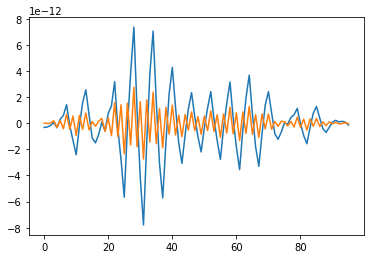

In [55]:
# Asymptotic vector.
e = x - multilevel[1].p.dot(multilevel[1].r.dot(x))
plt.plot(x);
plt.plot(e);

In [51]:
# L2 interpolation error
logger.info("|x-P*R*x|     {:.2e}".format(hm.linalg.scaled_norm(e)))
logger.info("|x|           {:.2e}".format(hm.linalg.scaled_norm(x)))

# Residual norm interpolation error
logger.info("|A*(x-P*R*x)| {:.2e}".format(hm.linalg.scaled_norm(multilevel[0].a.dot(e))))
logger.info("|Ax|          {:.2e}".format(hm.linalg.scaled_norm(multilevel[0].a.dot(x))))

INFO     |x-P*R*x|     9.54e-13
INFO     |x|           2.25e-12
INFO     |A*(x-P*R*x)| 4.70e-12
INFO     |Ax|          2.63e-12


In [67]:
nu_values = np.arange(1, 7, dtype=int)
r = multilevel[1].r
two_level_cycle = lambda y: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, 1, 0, nu_coarsest=-1, debug=False, rhs=b).run(y)
residual = lambda x: b - multilevel[0].operator(x)
b = np.random.random((a0.shape[0], ))
mock_conv_factor = np.array([
    hm.setup.auto_setup.mock_cycle_conv_factor(multilevel.finest_level, r, nu) 
    for nu in nu_values])
two_level_cycle = np.array([
    hm.solve.run.run_iterative_method(
        residual, 
        lambda x: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, nu, 0, nu_coarsest=-1, rhs=b).run(x), 
        np.random.random((multilevel.finest_level.size, )), 20)[1]
    for nu in nu_values])

for nu, mock, two_level in zip(nu_values, mock_conv_factor, two_level_cycle):
    print("V({}, {}) conv factor {:.3f} mock cycle {:.3f}".format(nu, 0, two_level, mock))

V(1, 0) conv factor 0.192 mock cycle 0.409
V(2, 0) conv factor 0.427 mock cycle 0.277
V(3, 0) conv factor 0.211 mock cycle 0.156
V(4, 0) conv factor 0.260 mock cycle 0.085
V(5, 0) conv factor 0.178 mock cycle 0.073
V(6, 0) conv factor 0.182 mock cycle 0.038


For some reason, 1 relaxation per cycle is more efficient than $2-4$ per cycle! Note that we are solving $Ax=b$, not $Ax=0$.

## Spectra of Different Levels

In [53]:
# Calculate eigenpairs at all levels.
vl = []
laml = []
for l, level in enumerate(multilevel):
    a = level.a
    lam, v = eig(a.todense())
    lam = np.real(lam)
    ind = np.argsort(np.abs(lam))
    lam = lam[ind]
    v = v[:, ind]
    vl.append(v)
    laml.append(lam)
    print(l, "lam", lam[:13])
    
# Interpolate eigenvectors at all levels to the finest level.
num_levels = len(multilevel)
vl_finest = []
for l in range(num_levels):
    v = vl[l]
    for k in range(l, 0, -1):
        v = multilevel[k].p.dot(v)
    vl_finest.append(v)

0 lam [-0.024 -0.024  0.04   0.04   0.096  0.096 -0.097 -0.097  0.143  0.143 -0.178 -0.178  0.181]
1 lam [-0.025 -0.025  0.04   0.04   0.095  0.095 -0.1   -0.1    0.14   0.14   0.177  0.177 -0.186]


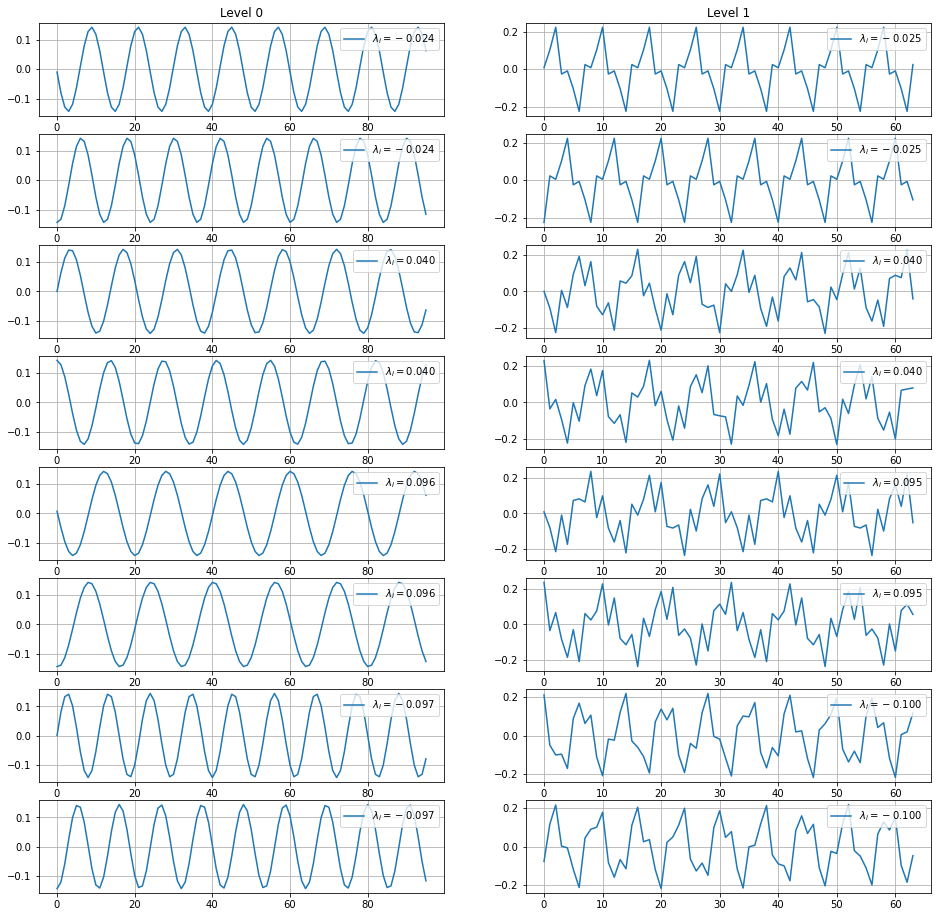

In [54]:
num_ev = 8
num_levels = len(multilevel)
fig, axs = plt.subplots(num_ev, num_levels, figsize=(16, 16))

for col, ax in enumerate(axs[0]):
    ax.set_title("Level {}".format(col))

for i in range(num_ev):
    for l in range(num_levels):
        ax = axs[i, l]
        ax.plot(np.real(vl[l][:, i]), label="$\lambda_i = {:.3f}$".format(laml[l][i]))
        ax.legend(loc="upper right")
        ax.grid(True);